# Define the libraries

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta
from scipy import signal

# Define the functions 

In [11]:
def PlotData(Begin,Duration,Mistake,OncourtFrame,OncourtVideo,Time,Data1,Data2,Figuur,player,df): 
    
    #Define starting en stopping positions for the CSV data
    Start = int((((OncourtFrame - OncourtVideo)*100) + Begin/10) - Mistake*100)
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    Timestamp = Time[Start:Stop]
   # -----------------------------------------------------------------------
        #LowPass Filter DON'T TOUCH
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)

   # -----------------------------------------------------------------------
        #Operations I have to do for user story   UNDERSTAND WHAT SUB AND CONV TRY TO EXPLAIN
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed#speeds addition
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    Conv2 = (abs(filtered_FrameRotationspeed)/abs(filtered_WheelRotationspeed))-filtered_WheelRotationspeed
    #Conv2 never sees use
    
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=1)
    DiffFrame = np.insert(DiffFrame,0,0)
    
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=1)
    DiffWheel = np.insert(DiffWheel,0,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    #same as conv but doesn´t see use

  # -----------------------------------------------------------------------
  
    #Visualize operations done (lower row of the subplot)
    fig, ax = plt.subplots(2,2)
    
    ax[1,1].plot(Timestamp,Conv1,'r')
    ax[1,0].plot(Timestamp,abs(DiffFrame),'b')
    
   # -----------------------------------------------------------------------
    
    
    #Set all data into a datafram including Sub, Conv1->Conv, DiffFrame, DiffWheel
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv','DiffFrame','DiffWheel'])
    
    # -----------------------------------------------------------------------
    
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
   
    #Search for the sprints
    Startsprint = []
    Stopsprint = []
    Sprinting = False
    Stop = True
    
  # -----------------------------------------------------------------------
    #print(Data_chunks['Conv']) isnt possible

    #  Detect Sprints
    
    #Use Sub en Conv to detect sprints
    for chunks in Data_chunks:
        print(chunks['Conv'].max())
        if abs(chunks['Conv'].max()) < 3 and chunks['Sub'].mean() > 300 and Sprinting == False:
            Startsprint.append(chunks['Time'].min())
            Sprinting = True
            Stop = False
        elif abs(chunks['Conv'].max() < 3) and chunks['Sub'].mean() > 300:
            Sprinting = True
            Stop = False
        elif Stop == False:
            Stopsprint.append(chunks['Time'].min())
            Sprinting = False
            Stop = True
    
  # -----------------------------------------------------------------------

    #Deect rotation
    
    #Use wheelrotation, framerotation and conv to detect rotations
    Startrotate = []
    Stoprotate = []
    Rotate = False
    Stop = True
    
    for chunks in Data_chunks:
        if abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4 and Rotate == False:
            Startrotate.append(chunks['Time'].min())
            Rotate = True
            Stop = False
        elif abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4:
            Rotate = True
            Stop = False
        elif Stop == False:
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
    
    print(Startrotate, Stoprotate)
    
    # -----------------------------------------------------------------------
    
    #Pop small sprints out 
    
    #Filter Sprints by lenght, if length is below 2 delete sprint
    Deleted = 0
    
    if len(Startsprint) > len(Stopsprint):
        Startsprint.pop(-1)
    
    if len(Startsprint) == len(Stopsprint):
        for i in range(0,len(Startsprint)-1):
            if (Stopsprint[i-Deleted] - Startsprint[i-Deleted]) < 2:
                Startsprint.pop(i-Deleted)
                Stopsprint.pop(i-Deleted)
                Deleted = Deleted + 1
    
    
   # -----------------------------------------------------------------------


    #Plot graph
    ax[0,0].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')#red is WheelRottion(wheel spins)
    ax[0,1].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')#blue is FrameRotation(frame turns)
    
    
  # -----------------------------------------------------------------------
        
    #Plot vertical lines and legend
    
    #Plot the vertical lines in plot 1
    for Start in Startsprint:
        ax[0,0].axvline(x=Start, color = 'g')
    for Stop in Stopsprint:
        ax[0,0].axvline(x=Stop, color = 'm')
    #ax[0,0].legend(['Wheel Rotation Speed','Frame Rotation Speed'])
    ax[0,0].set_xlabel('Time (sec)')
    ax[0,0].set_title("Fast Defence " + str(Figuur) + ", " + str(player) + ", Video Time = " 
                      + str(timedelta(seconds=(int(Begin/1000)-Mistake))))
    
    #Plot the vertical lines in plot 2
    for Start in Startrotate:
        ax[0,1].axvline(x=Start, color = 'g')
    for Stop in Stoprotate:
        ax[0,1].axvline(x=Stop, color = 'm')
    

# Visualize the data

###      Define player and match

In [12]:
Player = 8
Game = 2

### Insert data player

In [13]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Action = pd.read_csv('Ned_DUI_Game_' + str(Game) + '.csv')
df_Player

,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed
0,0.000000,0.0,0.0,0.0000,0.00000,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1,0.000000,0.0,0.0,0.0000,0.00000,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2,0.000000,0.0,0.0,0.0000,0.00000,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.000
3,0.000000,0.0,0.0,0.0000,0.00000,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,0.000000,0.0,0.0,0.0000,0.00000,0.05,NaN,NaN,NaN,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767580,-0.141610,4995.7,4011.8,-5.7383,-0.15038,7675.80,-0.28778,0.70778,-7.4978,-20.168,6.3622,3.8344,-21.853
767581,-0.091962,4995.7,4011.7,-5.9568,-0.15179,7675.80,-0.42636,0.77000,-7.7127,-20.216,6.3280,3.6960,-29.739
767582,-0.041869,4995.7,4011.6,-6.2542,-0.15271,7675.80,-0.45500,0.70000,-8.0150,-20.104,6.4960,3.5840,NaN
767583,NaN,NaN,NaN,NaN,NaN,NaN,-0.34222,0.51333,-8.3456,-19.880,6.7511,3.3444,NaN


# Define boundaries

## Get timestamps from CSV

In [14]:
df_Action_Player = df_Action.loc[df_Action["Players Group Box"] == ("Player " + str(Player))]
df_Action_Player_Fast_defence = df_Action_Player.loc[df_Action_Player["Player"] == "Fast defence"]#.iloc[::-1]
Timestamp = df_Action_Player_Fast_defence.Position.to_numpy()
print(len(Timestamp))
Timestamp

7


array([1311200, 2872960, 3705560, 3969520, 4092760, 4356240, 4397320])

### Sychronize

Times consist of the oncourt times in the video and the oncourt frames in Matlab

In [15]:
df_Sync = pd.read_csv('Sync_match_' + str(Game) + '.csv')
df_Sync_Player = df_Sync.loc[df_Sync["Player"] == Player]
Times = df_Sync_Player[["Video","Matlab"]].to_numpy()
Times[0][1]

3390.4

In [16]:
Error = [6,6,6,4,6,6,6,6,6,8,8]
print(len(Error))

11


### Visualize

ValueError: arrays must all be same length

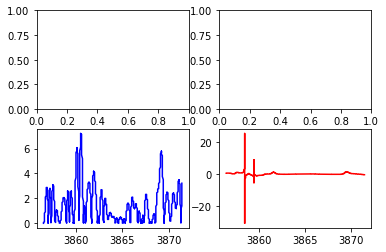

In [17]:
Quator = 0;
for i in range(0,len(Timestamp)):
    if Quator < (len(Times)-1):
        if Timestamp[i] >= (Times[Quator+1][0] * 1000):
            Quator = Quator + 1
#def PlotData(Begin,Duration,Mistake,OncourtFrame,OncourtVideo,Time,Data1,Data2,Figuur,player,df): 
    PlotData(Timestamp[i], 15, Error[i], Times[Quator][1], Times[Quator][0], df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i+1,('Player ' + str(Player)),df_Action)